In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = "2"
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Num GPUs Available:  3


In [2]:
from data_preprocess_functions import create_ziped_dataset1,buildDataSet,load_classes
from build_network import build_model,build_network_pretrained,getResNet50Model
from utils import DrawPics,drawTriplets
from learning_utils import compute_probs,get_batch_hard,get_batch_random,euclidean_distance,compute_dist,compute_metrics,compute_interdist,draw_interdist,draw_roc
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from sklearn.metrics import roc_curve,roc_auc_score
#from keras import backend as K
from tensorflow.keras.optimizers import Adam
import time
import os
import os.path
from os import path
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.regularizers import l2
#from keras import backend as K
from tensorflow.keras.utils import plot_model,normalize

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)

    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
class NetworkConfig:
	def __init__(self, min_samples=0):
		self.min_samples = min_samples
'''  '''
networkConfig = NetworkConfig()
networkConfig.model_path = None
networkConfig.min_samples = 10
networkConfig.data_location = "./labeled_20201020"
networkConfig.extend = '.png'
networkConfig.prepare_dir = ''
networkConfig.prepare_num = 100
networkConfig.prepare_test_size = 20/ float(100)
output_dir="."
projectName = "Weights"
project_path = './{0}/'.format(projectName)
model_path = '../{0}/'.format(projectName)
if not path.exists(project_path):
    os.mkdir(project_path)
if not path.exists(model_path):
    os.mkdir(model_path)
''' Define default parameters'''
BATCH_SIZE = 16
image_size = (224, 224)
input_shape = image_size + (3,)
nb_classes=39



In [3]:
"Classifier"

'Classifier'

In [4]:
def classifier(network, x_test_origin, dataset_train,test_label,refidx,top):
    t_start = time.time()
    predicted=[]
    _, w,h,c = dataset_train[0].shape
    nbimages=x_test_origin.shape[0]
    # planton spieces/ classes 
    classes = load_classes(networkConfig.data_location, networkConfig.extend, networkConfig.min_samples)
    nb_display=len(classes)
    nb_test_class=len(dataset_train)
    for i in range(0,nbimages):
        distdtype=[('class', int), ('dist', float)]
        dist1 = np.zeros(refidx, dtype=distdtype)
        #generates embedings for given images
        c=0;
        image_embedings = network.predict(np.expand_dims(x_test_origin[i,:,:,:],axis=0))
        for k in range(0,refidx):
            ref_images = np.zeros((nb_test_class,w,h,3))
            for j in range(0,nb_test_class):
                # generate random reference r
                #r= random.randint(0,dataset_train[k].shape[0])
                ref_images[j,:,:,:] = dataset_train[j][k,:,:,:]
                
            ref_embedings = network.predict(ref_images)  
            #Compute distances
            distdtype=[('class', int), ('dist', float)]
            dist = np.zeros(nb_test_class, dtype=distdtype)
            for ref in range(0,nb_test_class):
                #Compute distance between this images and references
                dist[ref] = (ref,compute_dist(image_embedings[:],ref_embedings[ref,:]))
                #dist[ref] = (ref,euclidean_distance(image_embedings[:],ref_embedings[ref,:]))
            #sort
            sorted_dist = np.sort(dist, order='dist')
            found=False
            for a in range(0,top):
                if (test_label[i]==classes[sorted_dist['class'][a]]):
                    predicted.append(classes[sorted_dist['class'][a]])
                    found=True;
                    c=c+1
                    break;
            if(found==True):
                break;
            else:
                dist1[k]=(sorted_dist['class'][0],sorted_dist['dist'][0])
        if(c==0):
            sorted_dist1 = np.sort(dist1, order='dist')
            predicted.append(classes[sorted_dist1['class'][0]])
    timeT=((time.time()-t_start)/60.0)
    return predicted, timeT  

In [5]:
def evaluation(top):
    correct=[]
    time_taken=[]
    for ns in range(1,7):
        totalCorr=[]
        timeCom=[]
        for i in range(1,6):
            gallary = []
            classes = load_classes(networkConfig.data_location, networkConfig.extend, networkConfig.min_samples)
            bn_classes=len(classes)
            #Sorting images by classes and normalize values 0=>1
            for n in range(0,bn_classes):
                images_class_n = np.asarray([row for idx,row in enumerate(x_train_origin) if y_train_origin[idx]==classes[n] ])
                index = np.random.choice(images_class_n.shape[0], ns, replace=False)
                selected_image=images_class_n[index]
                gallary.append(selected_image/255)
            [predicted,time_t]=classifier(base_model, x_test_origin, gallary, y_test_origin,ns,top)
            count=np.sum(predicted == y_test_origin)
            totalCorr.append(count)
            timeCom.append(time_t)        
        correct.append(totalCorr)
        time_taken.append(timeCom)
    return correct, time_taken


In [6]:
classes = load_classes(networkConfig.data_location, networkConfig.extend, networkConfig.min_samples)
print(len(classes))

50


In [ ]:
''' prepare and build dataset '''

In [ ]:
#prepare_dataset(networkConfig, output_dir, class_balance=10, augment=True)

In [ ]:
'''repair ziped dataset'''

In [7]:
PATH="."
train_dir = os.path.join(PATH, 'train_50')
validation_dir = os.path.join(PATH, 'test_50')

train_dataset = image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=image_size)
validation_dataset = image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=image_size)
class_names = train_dataset.class_names
class_names1 = validation_dataset.class_names
create_ziped_dataset1(train_dataset, validation_dataset)


Found 21681 files belonging to 50 classes.
Found 1574 files belonging to 50 classes.
Number of filtered classes:  50
Number of filtered classes:  50
Datset ziped


In [ ]:
" Create dataset for training and testing from the ziped data"

In [8]:
[dataset_train,dataset_test,x_train_origin,y_train_origin,x_test_origin,y_test_origin]=buildDataSet()
print("Checking shapes for class 0 (train) : ",dataset_train[1].shape)
print("Checking shapes for class 0 (test) : ",dataset_test[1].shape)
print("Checking first samples")
#for i in range(19,20):
    #DrawPics(dataset_train[49],5,template='Train {}',classnumber=i)
    #DrawPics(dataset_test[34],5,template='Test {}',classnumber=i)

Checking shapes for class 0 (train) :  (1000, 224, 224, 3)
Checking shapes for class 0 (test) :  (40, 224, 224, 3)
Checking first samples


In [ ]:
y_test_origin.shape

In [ ]:
''' prepareing pretrained CNN  model '''
"VGG19, VGG16, mobileNet, resNet50,inceptionV3"

In [ ]:
#base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

In [9]:
base_model=build_network_pretrained(input_shape,"VGG19",50)


In [ ]:
dataset_train[3].shape

In [ ]:
#base_model.trainable = False


In [ ]:
#base_model.summary()
len(base_model.non_trainable_variables)

In [ ]:
''' Get hardtriplets sample'''

In [ ]:
hardtriplets = get_batch_hard(10,1,1, base_model, dataset_train)
print("Shapes in the hardbatch A:{0} P:{1} N:{2}".format(hardtriplets[0].shape, hardtriplets[1].shape, hardtriplets[2].shape))
drawTriplets(hardtriplets)

In [ ]:
triplets = get_batch_random(1,dataset_train)

In [ ]:
"Build model"

In [10]:
model = build_model(input_shape,base_model)
optimizer = Adam(lr = 0.00006)
model.compile(loss=None,optimizer=optimizer)
#base_learning_rate = 0.000
#model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              #metrics=['accuracy'])

#base_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer="rmsprop", loss=triplet_loss, metrics=[accuracy])
#model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')
model.summary()
#plot_model(network_train,show_shapes=True, show_layer_names=True, to_file='02 model.png')
#print(model.metrics_names)
n_iteration=0
model.load_weights('{0}Best2_VGG19_50.h5'.format(model_path))
#model.load_weights('{0}Best4_VGG19_14.h5'.format(model_path))
#model.load_weights('{0}Best2_VGG19_39.h5'.format(model_path))
#model.load_weights('{0}Best2_VGG16_14.h5'.format(model_path))
#model.load_weights('{0}Best3_VGG16_50.h5'.format(model_path))

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tuned_model (Functional)        (None, 50)           421835890   anchor_input[0][0]               
                                                                 positive_input[0][0]  

In [ ]:
# triplets=hardtriplets
# loss = model.train_on_batch(triplets, None)

In [ ]:
#loss

In [ ]:
'''Visiualization'''

In [ ]:
#base_model.summary()
x_test_origin.shape

In [ ]:
evaluate_every = 50 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 800# No. of training iterations
n_val = 250 # how many one- shot tasks to validate on
log_every = 50
#####Testing on an untrained network
probs,yprob = compute_probs(base_model,x_test_origin,y_test_origin)
fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
draw_roc(fpr, tpr,thresholds,auc)
draw_interdist(base_model,0,dataset_test)

In [ ]:
"Train model"

In [ ]:
evaluate_every = 100 # interval for evaluating on one-shot tasks
batch_size = 16
n_iter = 5000# No. of training iterations
n_val = 100 # how many one- shot tasks to validate on
## # #
t_start = time.time()
n_iteration=0
loss19_history=[];
file = open("store.txt", "w")
for i in range(1, n_iter+1):
    #triplets = get_batch_random(batch_size,dataset_train)
    triplets=get_batch_hard(200,16,16,base_model,dataset_train)
    loss = model.train_on_batch(triplets, None)
    loss19_history.append(loss)
    #network_train.save_weights(file)
    file.write(" %s," %(loss))
    n_iteration += 1
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(i, (time.time()-t_start)/60.0,loss,n_iteration))
        #probs,yprob = compute_probs(base_model,x_test_origin[:500,:,:,:],y_test_origin[:500])
        #fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
        #draw_roc(fpr, tpr,thresholds,auc)
        #draw_interdist(base_model,0,dataset_test)
    #if i % 3000 == 0:
        #probs,yprob = compute_probs(base_model,x_test_origin[:150,:,:,:],y_test_origin[:150])
        #fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
        #draw_roc(fpr, tpr,thresholds,auc)
        #draw_interdist(base_model,i,dataset_test)
    if i % 2000==0:
        top=1
        [predicted,time_t]=classifier(base_model, x_test_origin, dataset_train,y_test_origin,1,top)
        Top1_count=np.sum(predicted == y_test_origin)
        print(Top1_count)
    if(i % 2000==0):
        probs,yprob = compute_probs(base_model,x_test_origin,y_test_origin)
        fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
        draw_roc(fpr, tpr,thresholds,auc)
        draw_interdist(base_model,i,dataset_test)
#Final save
model.save_weights('{0}Best3_VGG16_50.h5'.format(model_path))
top=1
[predicted,time_t]=classifier(base_model, x_test_origin, dataset_train,y_test_origin,1,1)
Top1_count=np.sum(predicted == y_test_origin)
print(Top1_count)

In [ ]:
''' Full evaluation '''

In [ ]:
#Full evaluation
n_iter = 10000
probs,yprob = compute_probs(base_model,x_train_origin[:500,:,:,:],y_train_origin[:500])
fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
draw_roc(fpr, tpr,thresholds,auc)
draw_interdist(base_model,n_iter,dataset_test)

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
# plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label='triploss learning')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC1',dpi=300)
plt.show();

In [ ]:
[predicted,time_t]=classifier(base_model, x_test_origin, dataset_train,y_test_origin,1,1)
Top1_count=np.sum(predicted == y_test_origin)
print(Top1_count)

In [ ]:
"Classification of test data set"

In [ ]:
''' generate random gallary images from the train images '''

In [45]:
correct=[]
prediction=[]
time_taken=[]
ns=12
top=1
gallary = []
classes = load_classes(networkConfig.data_location, networkConfig.extend, networkConfig.min_samples)
bn_classes=len(classes)
#Sorting images by classes and normalize values 0=>1
for n in range(0,bn_classes):
    images_class_n = np.asarray([row for idx,row in enumerate(x_train_origin) if y_train_origin[idx]==classes[n] ])
    index = np.random.choice(images_class_n.shape[0], ns, replace=False)
    selected_image=images_class_n[index]
    gallary.append(selected_image/255)
[predicted,time_t]=classifier(base_model, x_test_origin, gallary, y_test_origin,ns,top)
count=np.sum(predicted == y_test_origin)
correct.append(count)
time_taken.append(time_t)
prediction.append(predicted)


In [12]:
correct

[1125]

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
confusion_matrix=confusion_matrix(y_test_origin,predicted)
print(confusion_matrix.diagonal())
print(confusion_matrix.diagonal().sum())

In [ ]:
correct

In [ ]:
correct=[]
prediction=[]
time_taken=[]
ns=8
top=5
for i in range(1,6):
    gallary = []
    classes = load_classes(networkConfig.data_location, networkConfig.extend, networkConfig.min_samples)
    bn_classes=len(classes)
    #Sorting images by classes and normalize values 0=>1
    for n in range(0,bn_classes):
        images_class_n = np.asarray([row for idx,row in enumerate(x_train_origin) if y_train_origin[idx]==classes[n] ])
        index = np.random.choice(images_class_n.shape[0], ns, replace=False)
        selected_image=images_class_n[index]
        gallary.append(selected_image/255)
    [predicted,time_t]=classifier(base_model, x_test_origin, gallary, y_test_origin,ns,top)
    count=np.sum(predicted == y_test_origin)
    correct.append(count)
    time_taken.append(time_t)
    prediction.append(predicted)


In [ ]:
"Ploting of confusion matrix"

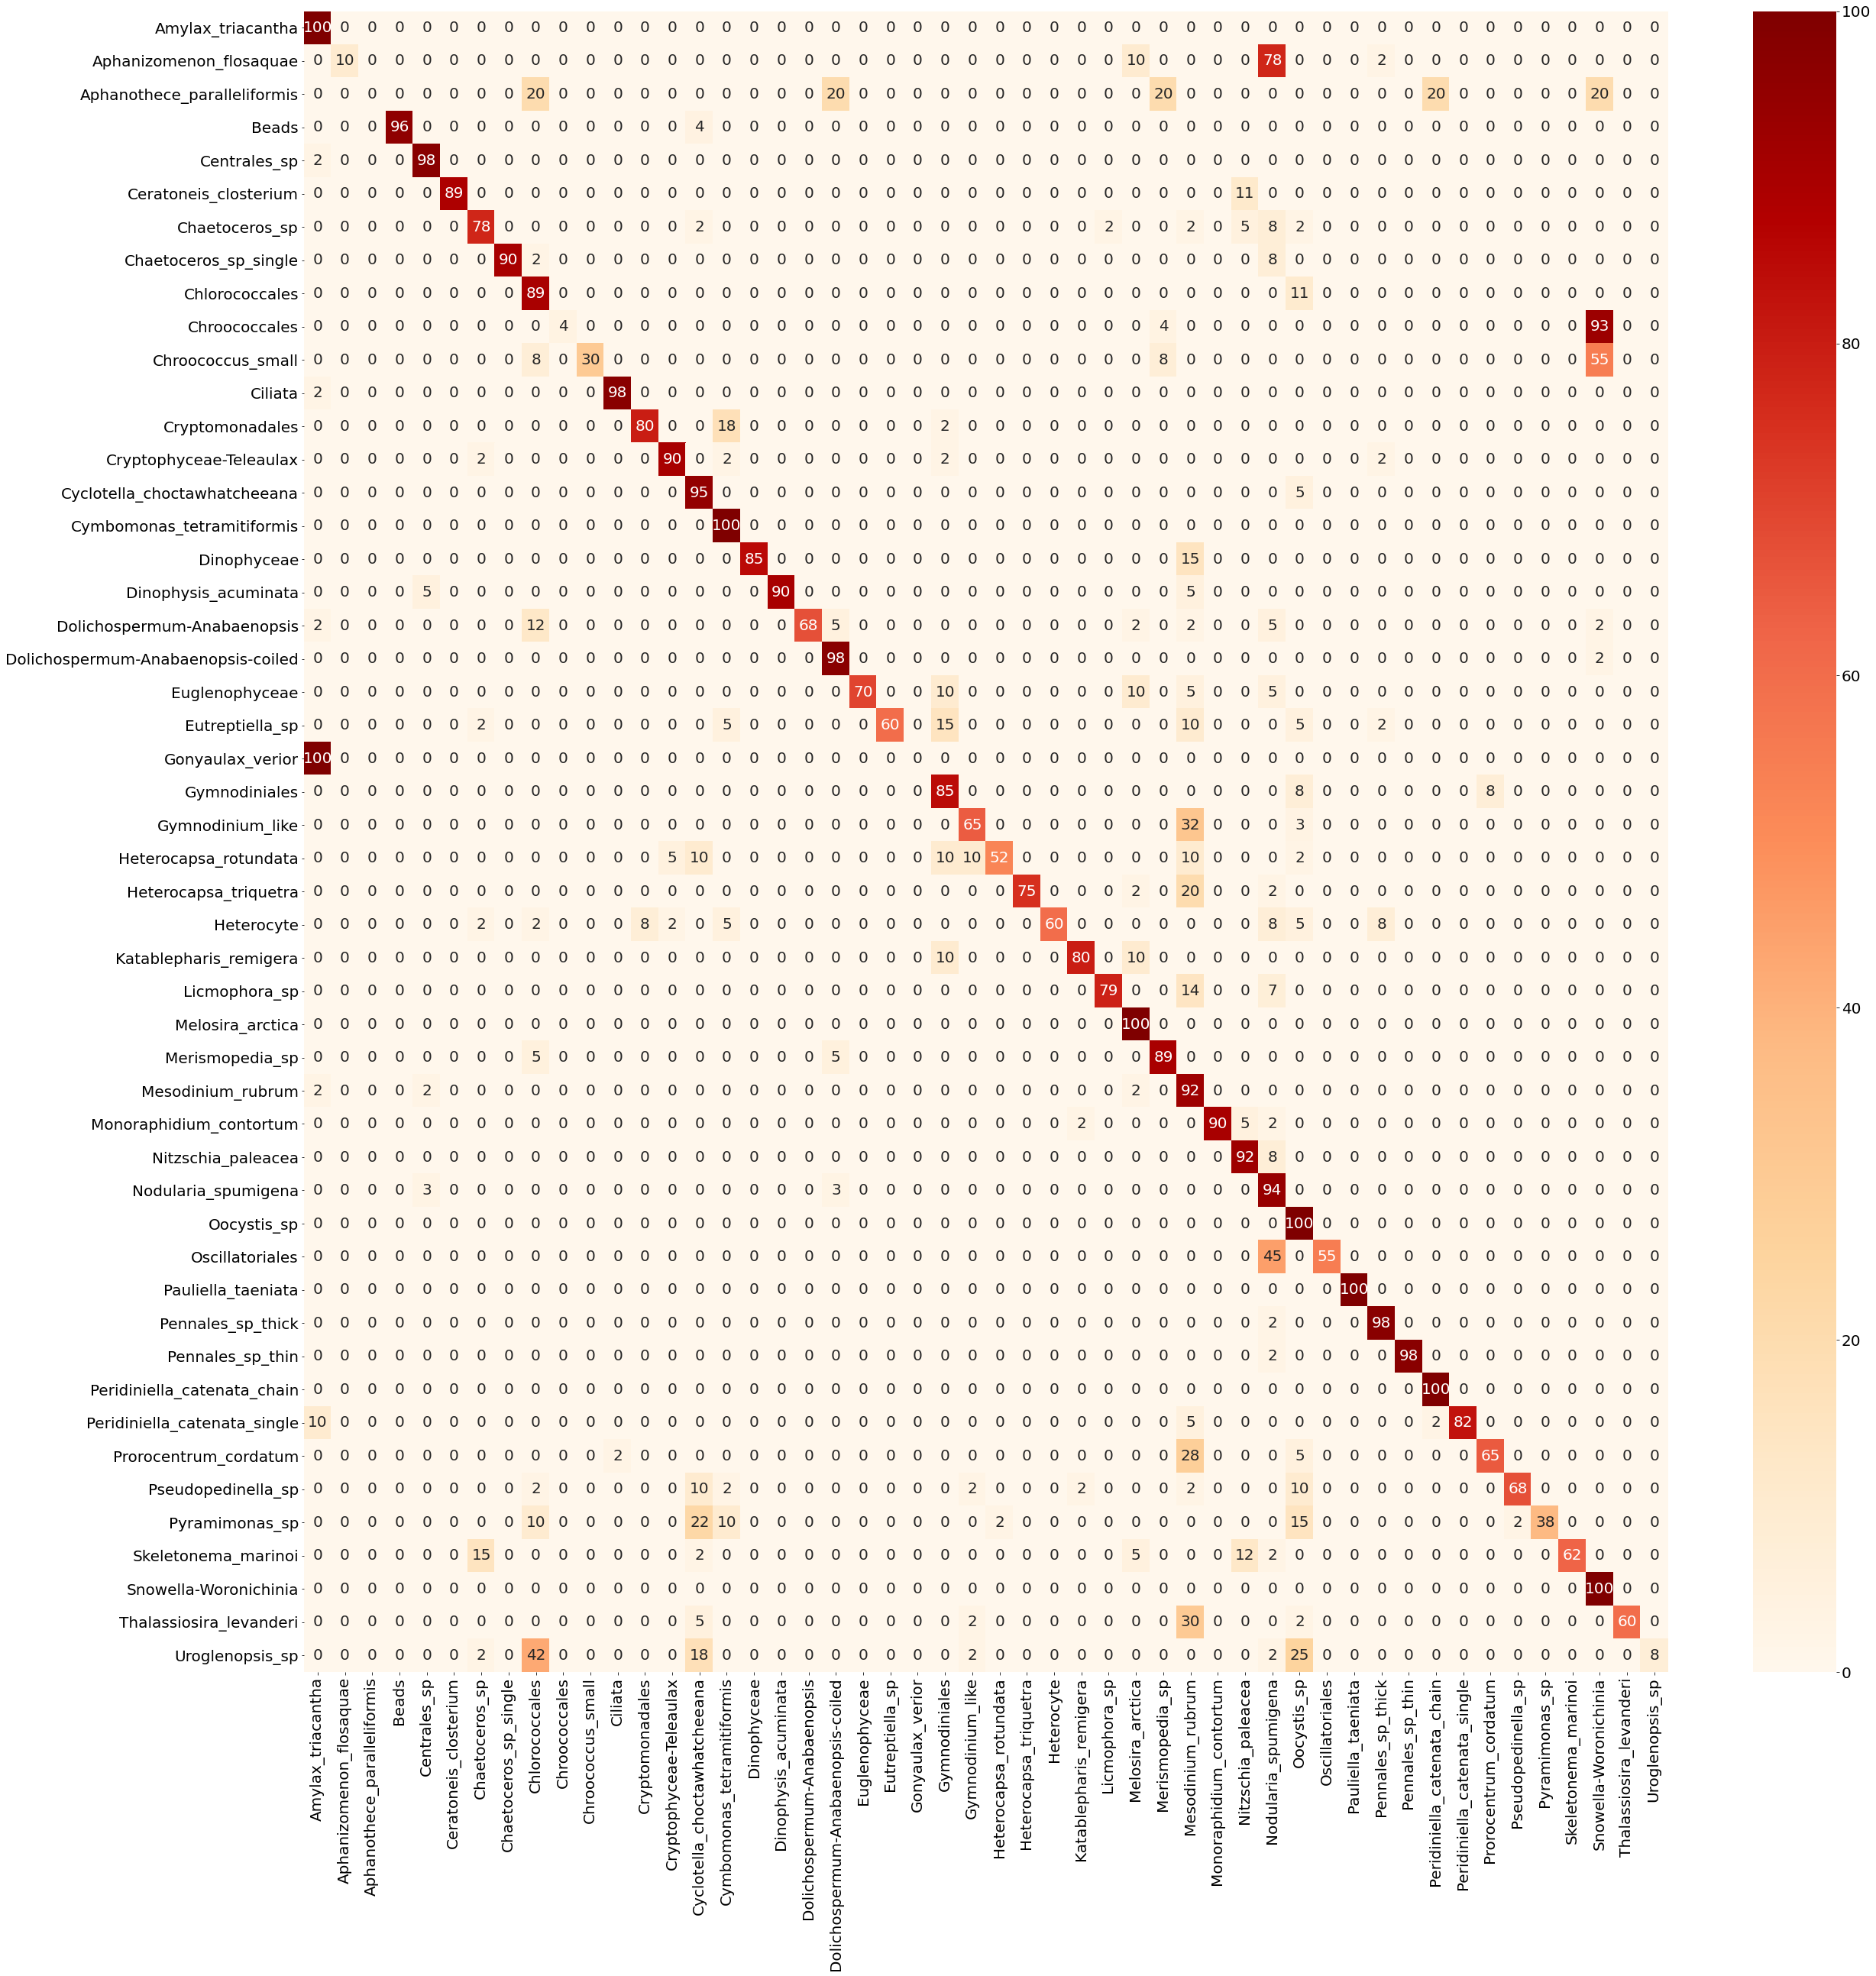

In [68]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
confusion_matrix=confusion_matrix(y_test_origin,predicted)
class_names = load_classes(networkConfig.data_location, networkConfig.extend, networkConfig.min_samples)
cmn = (confusion_matrix.astype('float')/confusion_matrix.sum(axis=-1)[:, np.newaxis])*100
df_cm = pd.DataFrame(cmn, index = [i for i in class_names],
              columns = [i for i in class_names])
plt.figure(figsize = (40,40))
sn.heatmap(df_cm, annot=True, fmt='.0f', cmap='OrRd', xticklabels=class_names, yticklabels=class_names)
results_path = 'results.png'
#print(results_path)
#plt.rcParams.update({'font.size':20})
#plt.savefig(results_path, dpi=400)
#plt.savefig('confusion_matrix'+str(learning_values.pop())+'.jpg')

In [ ]:
"plot sample test image with embeding distance"

In [ ]:
from learning_utils import draw_test_images
for i in range(1,10):
    draw_test_images(base_model,np.expand_dims(x_test_origin[i,:,:,:],axis=0),dataset_train,i,0.09)

In [ ]:

for i in range(312,320):
    draw_test_images(base_model,np.expand_dims(x_test_origin[i,:,:,:],axis=0),dataset_train,i,0.09)

In [ ]:
def draw_test_images(network, images, dataset_test,indx, threshold, classindicator=-1, refidx=0,nb_test_class=50 ):
    predicted=[]
    _, w,h,c = dataset_test[0].shape
    nbimages=images.shape[0]
    #generates embedings for given images
    image_embedings = network.predict(images)
    # planton spieces/ classes 
    classes = load_classes(networkConfig.data_location, networkConfig.extend, networkConfig.min_samples)
    nb_display=len(classes)
    nb_test_class=len(classes)
    #generates embedings for reference images
    ref_images = np.zeros((nb_test_class,w,h,c))
    for i in range(nb_test_class):
        ref_images[i,:,:,:] = dataset_test[i][refidx,:,:,:]
    ref_embedings = network.predict(ref_images)
    for i in range(nbimages):
        if nbimages>1:
            trueclass=i
        else:
            trueclass=classindicator
        
        #Prepare the figure
        fig=plt.figure(figsize=(50,50))
        subplot = fig.add_subplot(1,nb_display+1,1)
        #subplot.axis("off")
        plotidx = 3
            
        #Draw this image    
        plt.imshow(images[i,:,:,0])
        subplot.title.set_text("Test image")
            
        distdtype=[('class', int), ('dist', float)]
        dist = np.zeros(nb_test_class, dtype=distdtype)
        
        #Compute distances
        for ref in range(nb_test_class):
            #Compute distance between this images and references
            dist[ref] = (ref,compute_dist(image_embedings[i,:],ref_embedings[ref,:]))
        #sort
        sorted_dist = np.sort(dist, order='dist')
        predicted.append(classes[sorted_dist['class'][0]])
        #Draw
        for j in range(min(10,nb_test_class)):
            subplot = fig.add_subplot(1,nb_display+1,plotidx)
            plt.imshow(ref_images[sorted_dist['class'][j],:,:,0])
            #subplot.axis("off")
            #Red for sample above threshold
            if (sorted_dist['dist'][j] > threshold):
                if (trueclass == sorted_dist['class'][j]):
                    color = (1,0,0)
                    label = "TRUE"
                else:
                    color = (0.5,0,0)
                    label = "Class {0}".format(sorted_dist['class'][j])
            else:
                if (trueclass == sorted_dist['class'][j]):
                    color = (0, 1, 0)
                    label = "TRUE"
                else:
                    color = (0, .5, 0)
                    label = "Class {0}".format(sorted_dist['class'][j])
                
            subplot.set_title("{0}\n{1:.3e}".format(label,sorted_dist['dist'][j]))
            plotidx += 1
    return predicted

In [ ]:
"Top accuracy"

In [ ]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
objects = ('Top1', 'Top2', 'Top3', 'Top4', 'Top5')
y_pos = np.arange(len(objects))
performance = [Top1_count,Top2_count,Top3_count,Top4_count,Top5_count]
#performance = [83,97,106,113,123]
bar1=plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of correct classified species')
plt.title('Top accuracy')
# Add counts above the two bar graphs
for rect in bar1 :
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d ' % ((height*100)/len(y_test_origin)), ha='center', va='bottom')
plt.show()

In [ ]:
" Plot the accuracy with number of reference images from the gallery set for each classs"

In [ ]:
Top1_count=[0.54,0.59,0.61,0.64,0.65,0.6,0.67,0.72]
Top2_count=[0.72,0.80,0.83,0.84,0.86,0.86,0.89,92]
Top3_count=[0.83,0.86,0.89,0.90,0.90,0.91,0.91,93]
Top4_count=[0.90,0.91,0.91,0.92,0.93,0.93,0.935,95]
Top5_count=[0.93,0.93,0.94,0.94,0.94,0.95,0.95,96]

In [ ]:
"Plot graph"
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import math
  
# Using Numpy to create an array X
N = 7
X = [1,2,3,4,5,6,10]
figure, axis = plt.subplots(1, 1)
plt.tight_layout()
#plot second figure
# Plotting both the curves simultaneously
axis.plot(X, Top1_count, color='r', label='Top1')
axis.scatter(X, Top1_count, color='r', label='Top1')
axis.plot(X, Top2_count, color='g', label='Top2')
axis.scatter(X, Top2_count, color='g', label='Top2')
axis.plot(X, Top3_count, color='b', label='Top3')
axis.scatter(X, Top3_count, color='b', label='Top3')
axis.plot(X, Top4_count, color='k', label='Top4')
axis.scatter(X, Top4_count, color='k', label='Top4')
axis.plot(X, Top5_count, color='c', label='Top5')
axis.scatter(X, Top5_count, color='c', label='Top5')
# Naming the x-axis, y-axis and the whole graph
#axis[0,1].set_xlabel("Number of each sample reference images")
axis.set_ylabel("Acuracy")
axis.set_xlabel("Number of references")
axis.set_title("Acuracy vs number of references")
# Adding legend, which helps us recognize the curve according to it's color
axis.legend(prop={"size":7})
#plot second figure
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test_origin,predicted)
# Normalise
cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='OrRd', xticklabels=class_names, yticklabels=class_names)
results_path = 'results.jpg'
#print(results_path)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
plt.savefig(results_path, dpi=400)